# CICIDS2017 – Intrusion Detection with Benign Undersampling & Grid Search

**Authors:** Sinan HASAN TAWFIQ, Nguyen LE NGUYEN, Jethendiran VELU
**Dataset:** CICIDS2017 – Canadian Institute for Cybersecurity  

This notebook builds an intrusion detection system on CICIDS2017 with:

1. Robust loading and cleaning of multiple CSV files  
2. Strong class imbalance handling by **undersampling the Benign class**  
3. A clean preprocessing pipeline (ColumnTransformer + Pipeline)  
4. Baseline model comparison with cross-validation  
5. Hyperparameter tuning using **GridSearchCV**  
6. Final evaluation and feature importance analysis  



In [1]:
# --- Explanation (cell 1: imports & configuration) ---
# This cell imports all the Python libraries and tools that will be used
# throughout the notebook and configures a few global options:
# - Turn off non‑critical warnings (for cleaner output).
# - Import numpy, pandas, seaborn, matplotlib and Path for numerical work,
#   data manipulation, visualisation and filesystem paths.
# - Import scikit‑learn utilities for:
#     * splitting the data (train_test_split, StratifiedKFold),
#     * building preprocessing pipelines (ColumnTransformer, Pipeline,
#       SimpleImputer, StandardScaler),
#     * training models (LogisticRegression, LinearSVC, RandomForest,
#       GradientBoosting and optionally XGBoost),
#     * and computing evaluation metrics (accuracy, precision, recall,
#       F1‑score, ROC‑AUC, confusion matrix, classification report).
# - Try to import XGBClassifier; if it is available, set
#   `XGBOOST_AVAILABLE = True`, otherwise set it to False. This flag is
#   used later to optionally include XGBoost in the list of models.
# - Set pandas display options to show up to 200 rows and columns so that
#   large tables are easier to inspect in the notebook.
# - Apply a default seaborn / matplotlib style for consistent plots.
# - Fix the random seed (`RANDOM_STATE`) for numpy so that sampling,
#   train/test splits and model training are reproducible.
# - Define `DATA_DIR` pointing to the folder that should contain the raw
#   CICIDS2017 CSV files and print its resolved path and existence status.

# =====================================
# 1) Imports & global configuration
# =====================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

sns.set_theme()
plt.style.use("default")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_DIR = Path("./data")
print("DATA_DIR:", DATA_DIR.resolve(), "| exists:", DATA_DIR.exists())


DATA_DIR: C:\Users\shasa\Downloads\data | exists: True


In [2]:
# --- Explanation (cell 2: data loading & concatenation) ---
# This cell defines helper functions for loading the CICIDS2017 CSV files
# and then actually loads a subset of the data:
# - `normalize_columns(df)` cleans the column names of a DataFrame by:
#     * replacing non‑breaking spaces and zero‑width spaces,
#     * stripping leading/trailing spaces,
#     * collapsing multiple spaces into a single space.
#   This is important because some raw CSVs may contain slightly different
#   or "noisy" column names.
# - `looks_like_cicids(name)` returns True if a filename looks like a
#   CICIDS "workinghours" CSV (based on substrings in the file name).
# - `load_cicids_flexible(...)`:
#     * checks that the `data_dir` exists,
#     * lists all CSV files whose names look like CICIDS files,
#     * raises an error if no suitable files are found,
#     * prints the list of candidate CSV files,
#     * for each file:
#           - reads the CSV into a DataFrame,
#           - normalises the column names with `normalize_columns`,
#           - optionally randomly samples up to `samples_per_file` rows
#             (to reduce memory and balance the contribution of each file),
#           - stores each partial DataFrame in a list,
#     * computes the set of column names that are common to all loaded
#       DataFrames; if there is no intersection, it raises an error,
#     * concatenates all partial DataFrames using only the common columns
#       and prints the final combined shape,
#     * returns the concatenated DataFrame.
# - Finally, `df_raw = load_cicids_flexible(samples_per_file=120_000)`
#   loads up to 120k rows from each matching CSV file and `df_raw.head()`
#   shows the first few rows to visually inspect the loaded data.

# =====================================
# 2) Flexible data loading with per-file sampling
# =====================================

def normalize_columns(df: pd.DataFrame) -> pd.Index:
    """Normalize column names: remove weird spaces and invisible characters."""
    return (
        df.columns
          .str.replace("\xa0", " ", regex=False)
          .str.replace("\u200b", "", regex=False)
          .str.strip()
          .str.replace(r"\s+", " ", regex=True)
    )

def looks_like_cicids(name: str) -> bool:
    n = name.lower()
    return ("workinghours" in n) and ("pcap_iscx" in n)

def load_cicids_flexible(
    data_dir: Path = DATA_DIR,
    samples_per_file: int | None = 120_000,
    random_state: int = 42
) -> pd.DataFrame:
    assert data_dir.exists(), f"Folder not found: {data_dir.resolve()}"
    csvs = sorted([p for p in data_dir.glob("*.csv") if looks_like_cicids(p.name)])
    if not csvs:
        raise FileNotFoundError(f"No CICIDS-like CSVs found in {data_dir.resolve()}")

    print(f"Found {len(csvs)} candidate CSV files:")
    for p in csvs:
        print("  -", p.name)

    rng = np.random.RandomState(random_state)
    dfs = []
    for f in csvs:
        df_part = pd.read_csv(f, low_memory=False)
        df_part.columns = normalize_columns(df_part)
        if samples_per_file is not None and len(df_part) > samples_per_file:
            df_part = df_part.sample(n=samples_per_file, random_state=rng)
        dfs.append(df_part)
        print(f"  -> {f.name:40s} subset shape: {df_part.shape}")

    common = set(dfs[0].columns)
    for d in dfs[1:]:
        common &= set(d.columns)
    if not common:
        raise ValueError("No common columns across CSVs. Please check your files.")

    cols = sorted(common)
    df_all = pd.concat([d[cols].copy() for d in dfs], ignore_index=True)
    print("Concatenated shape:", df_all.shape)
    return df_all

df_raw = load_cicids_flexible(samples_per_file=120_000)
df_raw.head()


Found 8 candidate CSV files:
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  - Friday-WorkingHours-Morning.pcap_ISCX.csv
  - Monday-WorkingHours.pcap_ISCX.csv
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  - Tuesday-WorkingHours.pcap_ISCX.csv
  - Wednesday-workingHours.pcap_ISCX.csv
  -> Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv subset shape: (120000, 79)
  -> Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv subset shape: (120000, 79)
  -> Friday-WorkingHours-Morning.pcap_ISCX.csv subset shape: (120000, 79)
  -> Monday-WorkingHours.pcap_ISCX.csv        subset shape: (120000, 79)
  -> Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv subset shape: (120000, 79)
  -> Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv subset shape: (120000, 79)
  -> Tuesday-WorkingHours.pcap_ISCX.csv       subset shape: (120000, 79)
  -> Wedn

,ACK Flag Count,Active Max,Active Mean,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Header Length,Bwd IAT Max,Bwd IAT Mean,Bwd IAT Min,Bwd IAT Std,Bwd IAT Total,Bwd PSH Flags,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Min,Bwd Packet Length Std,Bwd Packets/s,Bwd URG Flags,CWE Flag Count,Destination Port,Down/Up Ratio,ECE Flag Count,FIN Flag Count,Flow Bytes/s,Flow Duration,Flow IAT Max,Flow IAT Mean,Flow IAT Min,Flow IAT Std,Flow Packets/s,Fwd Avg Bulk Rate,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Header Length,Fwd Header Length.1,Fwd IAT Max,Fwd IAT Mean,Fwd IAT Min,Fwd IAT Std,Fwd IAT Total,Fwd PSH Flags,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,Fwd Packet Length Std,Fwd Packets/s,Fwd URG Flags,Idle Max,Idle Mean,Idle Min,Idle Std,Init_Win_bytes_backward,Init_Win_bytes_forward,Label,Max Packet Length,Min Packet Length,PSH Flag Count,Packet Length Mean,Packet Length Std,Packet Length Variance,RST Flag Count,SYN Flag Count,Subflow Bwd Bytes,Subflow Bwd Packets,Subflow Fwd Bytes,Subflow Fwd Packets,Total Backward Packets,Total Fwd Packets,Total Length of Bwd Packets,Total Length of Fwd Packets,URG Flag Count,act_data_pkt_fwd,min_seg_size_forward
0,1,1982,1.982000e+03,1982,0.0000,7.500000,0.000000,6.000000,0,0,0,0,0,0.000000e+00,0,0.000000e+00,0,0,0,0.000000,0,0.000000,0.000000,0,0,80,0,0,0,2.555125e+00,9392887,9390905,3.130962e+06,975,5.421269e+06,0.425854,0,0,0,80,80,9390905,3.130962e+06,975,5.421269e+06,9392887,0,6,6.000000,6,0.000000,0.425854,0,9390905,9390905.0,9390905,0.0000,-1,256,DDoS,6,6,0,6.000000,0.000000,0.000000e+00,0,0,0,0,24,4,0,4,0,24,0,3,20
1,1,27151,2.715100e+04,27151,0.0000,7.000000,6.000000,6.000000,0,0,0,100,5410860,1.355718e+06,3,2.703434e+06,5422871,0,6,6.000000,6,0.000000,0.919454,0,0,64007,5,0,0,6.620068e+00,5438011,5410860,1.087602e+06,3,2.416784e+06,1.103345,0,0,0,20,20,0,0.000000e+00,0,0.000000e+00,0,0,6,6.000000,6,0.000000,0.183891,0,5410860,5410860.0,5410860,0.0000,0,229,BENIGN,6,6,0,6.000000,0.000000,0.000000e+00,0,0,30,5,6,1,5,1,30,6,1,0,20
2,0,566475,1.609163e+05,120118,134508.6864,148.314286,230.866667,86.400000,0,0,0,488,10200000,8.061410e+06,121410,4.296214e+06,113000000,0,1734,230.866667,0,514.538471,0.129740,0,0,80,0,0,0,4.489878e+01,115615609,10100000,3.400459e+06,17,4.722346e+06,0.302727,0,0,0,648,648,10200000,6.085032e+06,118,5.002940e+06,116000000,0,578,86.400000,0,211.017934,0.172987,0,10100000,10100000.0,9988018,46752.4843,255,29200,BENIGN,1734,0,1,144.194444,368.503446,1.357948e+05,0,0,3463,15,1728,20,15,20,3463,1728,0,3,32
3,0,0,0.000000e+00,0,0.0000,1453.375000,2320.200000,8.666667,0,0,0,112,8150,2.445000e+03,190,3.835651e+03,9780,0,7300,2320.200000,0,3022.508098,508.802279,0,0,80,1,0,0,1.183169e+06,9827,7954,1.403857e+03,4,2.919354e+03,814.083647,0,0,0,72,72,8001,4.002500e+03,4,5.654733e+03,8005,0,20,8.666667,0,10.263203,305.281368,0,0,0.0,0,0.0000,229,8192,DDoS,7300,0,1,1291.888889,2460.652985,6.054813e+06,0,0,11601,5,26,3,5,3,11601,26,0,2,20
4,1,4219842,4.219842e+06,4219842,0.0000,729.687500,6.888889,1658.142857,0,0,0,192,82600000,1.090000e+07,0,2.900000e+07,86900000,0,20,6.888889,0,5.301991,0.102759,0,0,53315,1,0,0,1.332331e+02,87583370,82600000,5.838891e+06,0,2.130000e+07,0.182683,0,0,0,152,152,86800000,1.460000e+07,49,3.540000e+07,87600000,0,4380,1658.142857,0,1762.272815,0.079924,0,82600000,82600000.0,82600000,0.0000,256,229,BENIGN,4380,0,0,686.764706,1366.162670,1.866400e+06,0,0,62,9,11607,7,9,7,62,11607,1,5,20


Detected label column: 'Label'
Shape: (960000, 79)


,label,count,ratio
0,BENIGN,775096,0.807392
1,DDoS,68025,0.070859
2,PortScan,66709,0.069489
3,DoS Hulk,40014,0.041681
4,FTP-Patator,2121,0.002209
5,DoS GoldenEye,1796,0.001871
6,SSH-Patator,1588,0.001654
7,Bot,1231,0.001282
8,Web Attack � Brute Force,1028,0.001071
9,DoS slowloris,1007,0.001049


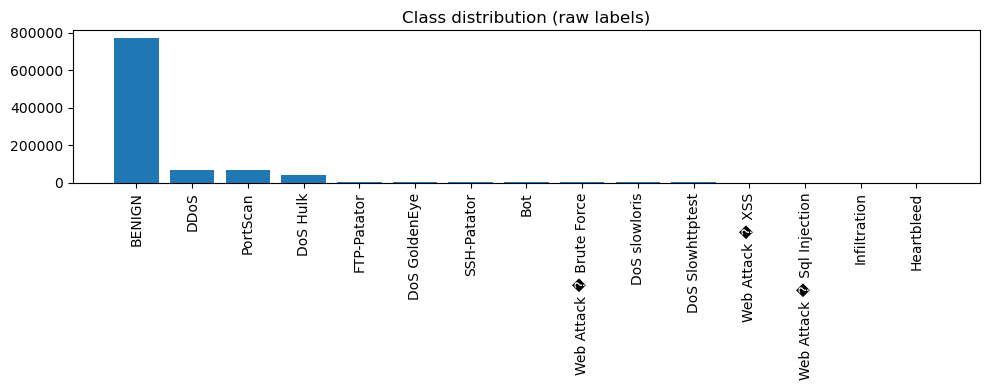

In [3]:
# --- Explanation (cell 3: target/label cleaning & class counts) ---
# This cell locates the target label column, cleans it and analyses the
# distribution of classes:
# - `find_label_column(columns)` scans the list of column names to find a
#   reasonable candidate for the target variable by:
#     * first looking for common names such as "Label", "Attack", "Class"
#       (in various capitalisations),
#     * then matching lower‑cased/stripped names,
#     * finally falling back to any column whose name ends with "label".
#   It returns the chosen column name or None if nothing matches.
# - `label_col` stores the detected label column; if nothing is found,
#   the code raises a ValueError listing all available columns.
# - A working copy `df` is created from `df_raw`.
# - The label column is cleaned by:
#     * converting values to string,
#     * replacing non‑breaking spaces with normal spaces,
#     * stripping leading/trailing whitespace.
#   This ensures consistent label values, e.g. "BENIGN", "Benign ",
#   " BENIGN" all become a clean, comparable string.
# - The overall shape of the cleaned DataFrame is printed.
# - `label_counts` is computed as a table with:
#     * the unique label values,
#     * the count of samples per label,
#     * and the proportion (`ratio`) of each label in the dataset.
#   It is displayed so that we can inspect how imbalanced the dataset is.
# - A bar plot is then drawn to visualise the class distribution of the
#   raw labels before any rebalancing or undersampling is applied.

# =====================================
# 3) Label detection & basic class analysis
# =====================================

def find_label_column(columns) -> str | None:
    candidates = ["Label", "label", "Attack", "attack", "Class", "class"]
    for c in candidates:
        if c in columns:
            return c
    lowmap = {c.strip().lower(): c for c in columns}
    for key in ["label", "attack", "class"]:
        if key in lowmap:
            return lowmap[key]
    for c in columns:
        if c.strip().lower().endswith("label"):
            return c
    return None

label_col = find_label_column(df_raw.columns)
if label_col is None:
    raise ValueError(f"Target column not found. Available columns: {df_raw.columns.tolist()}")

print("Detected label column:", repr(label_col))

df = df_raw.copy()
df[label_col] = (
    df[label_col]
      .astype(str)
      .str.replace("\xa0", " ", regex=False)
      .str.strip()
)

print("Shape:", df.shape)
label_counts = (
    df[label_col]
      .value_counts()
      .rename_axis("label")
      .reset_index(name="count")
)
label_counts["ratio"] = label_counts["count"] / label_counts["count"].sum()
display(label_counts.head(20))

plt.figure(figsize=(10, 4))
plt.bar(label_counts["label"].astype(str), label_counts["count"])
plt.title("Class distribution (raw labels)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Benign samples: 775096
Attack samples: 184904
After benign undersampling:
  Benign: 184904
  Attack: 184904
  Total : 369808


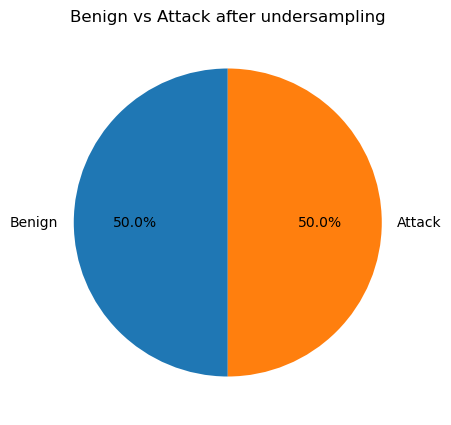

In [4]:
# --- Explanation (cell 4: benign undersampling for class balance) ---
# This cell reduces the strong class imbalance between benign and attack
# traffic by undersampling the majority "Benign" class:
# - `is_benign` is a boolean mask that marks samples whose label contains
#   the word "benign" (case‑insensitive).
# - `df_benign` contains only benign samples; `df_attack` contains all
#   non‑benign samples (i.e. attacks).
# - The number of benign and attack samples is printed.
# - `max_benign_kept` is set to the smaller of the two class sizes, so
#   that the final dataset will have roughly a 1:1 ratio between benign
#   and attack.
# - `df_benign_sampled` randomly samples `max_benign_kept` rows from the
#   benign subset, using the fixed `RANDOM_STATE` for reproducibility.
# - `df_balanced` is created by concatenating:
#     * the undersampled benign subset
#     * and all attack samples.
#   The combined dataset is then shuffled and its index reset.
# - The number of benign vs attack samples after rebalancing is printed.
# - A small pie chart is drawn that shows the final proportion of benign
#   vs attack traffic after benign undersampling. This balanced dataset
#   is what will be used in the following steps.

# =====================================
# 4) Benign undersampling to reduce huge class imbalance
# =====================================

is_benign = df[label_col].str.lower().str.contains("benign")
df_benign = df[is_benign].copy()
df_attack = df[~is_benign].copy()

print("Benign samples:", len(df_benign))
print("Attack samples:", len(df_attack))

max_benign_kept = min(len(df_benign), len(df_attack))  # 1:1 ratio
df_benign_sampled = df_benign.sample(
    n=max_benign_kept,
    random_state=RANDOM_STATE
)

df_balanced = pd.concat([df_benign_sampled, df_attack], ignore_index=True)
df_balanced = df_balanced.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

print("After benign undersampling:")
print("  Benign:", (df_balanced[label_col].str.lower().str.contains("benign")).sum())
print("  Attack:", (~df_balanced[label_col].str.lower().str.contains("benign")).sum())
print("  Total :", len(df_balanced))

plt.figure(figsize=(5, 5))
counts_binary = [
    (df_balanced[label_col].str.lower().str.contains("benign")).sum(),
    (~df_balanced[label_col].str.lower().str.contains("benign")).sum(),
]
plt.pie(
    counts_binary,
    labels=["Benign", "Attack"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Benign vs Attack after undersampling")
plt.show()


In [5]:
# --- Explanation (cell 5: feature cleaning, pruning & train/test split) ---
# This is the main preprocessing cell. It prepares the feature matrix X
# and label vector y, cleans the features, removes low‑quality columns,
# defines preprocessing pipelines and finally splits the data:
# 1) Basic split into features and labels:
#    - `df_work` is a copy of the balanced DataFrame.
#    - `y` is the cleaned label column.
#    - `X` contains all columns except the label.
# 2) Type conversion & numeric cleaning:
#    - All non‑numeric columns in X are converted to numeric using
#      `pd.to_numeric(..., errors="coerce")`; values that cannot be
#      converted become NaN.
#    - Any +inf / -inf values are replaced by NaN.
# 3) Heuristic feature pruning:
#    - `id_like` collects columns whose names look like identifiers or
#      metadata (e.g. containing "id", "flow id", "src ip", etc.). Such
#      columns are dropped because they do not represent useful features
#      for learning patterns and can easily leak information.
#    - Duplicate column names are detected and removed so that each
#      feature appears only once.
#    - Columns with more than 30% missing values are dropped, as they
#      are considered too incomplete to be reliable.
#    - For numeric columns, the standard deviation is computed; columns
#      with (near) zero standard deviation are treated as quasi‑constant
#      features and removed, because they carry almost no information.
#    - A correlation matrix (absolute values) is computed for the
#      remaining numeric columns; for each feature, if there exists
#      another feature with correlation > 0.98, that feature is added to
#      `to_drop_corr` and removed. This step removes highly redundant
#      features.
#    - All groups of dropped columns (identifiers, duplicates, too many
#      missing values, near‑constant features, highly correlated
#      features) are printed in a small report so that the user can see
#      exactly what has been removed.
# 4) Final feature sets & preprocessing pipelines:
#    - `X_clean` and `y_clean` are copies of the pruned feature matrix
#      and labels.
#    - `num_cols` lists the remaining numeric columns, and `cat_cols`
#      lists any remaining non‑numeric columns.
#    - The final shape of X and the count of numeric vs categorical
#      features are printed.
#    - Two preprocessing pipelines are defined:
#        * `numeric_pipeline`: imputes missing numeric values with the
#          median and then standardises them with `StandardScaler`.
#        * `categorical_pipeline`: imputes missing categorical values
#          with the most frequent value.
#    - These pipelines are combined into a `ColumnTransformer` called
#      `preprocess` so that the same cleaning and scaling steps can be
#      applied consistently inside scikit‑learn models.
# 5) Filtering rare classes & creating the train/test split:
#    - `class_counts` counts how many samples there are for each class.
#    - `valid_classes` keeps only classes that appear at least twice.
#      This is necessary so that stratified splitting does not fail.
#    - `X_clean_strat` and `y_clean_strat` keep only rows belonging to
#      the valid classes, and the resulting distribution and shapes are
#      printed.
#    - Finally, `train_test_split` creates training and test sets with
#      a 70%/30% split, stratified by the (filtered) target labels and
#      using `RANDOM_STATE` for reproducibility. The final train/test
#      shapes are printed.

# =====================================
# 5) Preprocessing & feature cleaning
# =====================================

df_work = df_balanced.copy()

y = df_work[label_col].astype(str).str.strip()
X = df_work.drop(columns=[label_col])

for c in X.columns:
    if not np.issubdtype(X[c].dtype, np.number):
        X[c] = pd.to_numeric(X[c], errors="coerce")

X = X.replace([np.inf, -np.inf], np.nan)

dropped = {"identifiers": [], "duplicates": [], "too_missing": [], "near_constant": [], "high_corr": []}

id_like = [c for c in ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Fwd Header Length.1"] if c in X.columns]
if id_like:
    dropped["identifiers"].extend(id_like)
    X = X.drop(columns=id_like)

duplicated_names = X.columns[X.columns.duplicated()].tolist()
if duplicated_names:
    dropped["duplicates"].extend(duplicated_names)
    X = X.loc[:, ~X.columns.duplicated()]

missing_ratio = X.isna().mean()
too_missing = missing_ratio[missing_ratio > 0.30].index.tolist()
if too_missing:
    dropped["too_missing"].extend(too_missing)
    X = X.drop(columns=too_missing)

num_cols_tmp = X.select_dtypes(include=[np.number]).columns
stds = X[num_cols_tmp].std()
near_const = stds[stds < 1e-8].index.tolist()
if near_const:
    dropped["near_constant"].extend(near_const)
    X = X.drop(columns=near_const)

num_cols_tmp = X.select_dtypes(include=[np.number]).columns
corr = X[num_cols_tmp].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.98)]
if to_drop_corr:
    dropped["high_corr"].extend(to_drop_corr)
    X = X.drop(columns=to_drop_corr)

def _print_drop_group(title, cols):
    print(f"{title} ({len(cols)})")
    if cols:
        display(pd.DataFrame({"dropped_columns": sorted(cols)}))

print("=== Feature pruning report ===")
_print_drop_group("Identifiers / metadata", dropped["identifiers"])
_print_drop_group("Duplicated columns", dropped["duplicates"])
_print_drop_group("Too many missing (>30%)", dropped["too_missing"])
_print_drop_group("Near-constant std", dropped["near_constant"])
_print_drop_group("High correlation (>0.98)", dropped["high_corr"])

X_clean = X.copy()
y_clean = y.copy()

num_cols = X_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_clean.columns if c not in num_cols]

print("Final feature matrix shape:", X_clean.shape)
print("Numeric features:", len(num_cols), "| Categorical features:", len(cat_cols))

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols),
    ],
    remainder="drop",
)

# Filtrer les classes trop rares pour permettre une stratification correcte
class_counts = y_clean.value_counts()
valid_classes = class_counts[class_counts >= 2].index  # >= 2 échantillons par classe

X_clean_strat = X_clean[y_clean.isin(valid_classes)]
y_clean_strat = y_clean[y_clean.isin(valid_classes)]

print("Class distribution after filtering rare classes:")
print(y_clean_strat.value_counts())
print("Shapes after filtering:", X_clean_strat.shape, "labels:", y_clean_strat.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_clean_strat, y_clean_strat,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y_clean_strat,
)
# ================================

print("Train:", X_train.shape, "Test:", X_test.shape)


=== Feature pruning report ===
Identifiers / metadata (1)


,dropped_columns
0,Fwd Header Length.1


Duplicated columns (0)
Too many missing (>30%) (0)
Near-constant std (8)


,dropped_columns
0,Bwd Avg Bulk Rate
1,Bwd Avg Bytes/Bulk
2,Bwd Avg Packets/Bulk
3,Bwd PSH Flags
4,Bwd URG Flags
5,Fwd Avg Bulk Rate
6,Fwd Avg Bytes/Bulk
7,Fwd Avg Packets/Bulk


High correlation (>0.98) (20)


,dropped_columns
0,Bwd Packet Length Mean
1,Bwd Packet Length Std
2,Fwd IAT Max
3,Fwd IAT Total
4,Fwd Packet Length Mean
5,Fwd Packets/s
6,Fwd URG Flags
7,Idle Max
8,Idle Mean
9,Idle Min


Final feature matrix shape: (369808, 49)
Numeric features: 49 | Categorical features: 0
Class distribution after filtering rare classes:
Label
BENIGN                        184904
DDoS                           68025
PortScan                       66709
DoS Hulk                       40014
FTP-Patator                     2121
DoS GoldenEye                   1796
SSH-Patator                     1588
Bot                             1231
Web Attack � Brute Force        1028
DoS slowloris                   1007
DoS Slowhttptest                 903
Web Attack � XSS                 454
Web Attack � Sql Injection        15
Infiltration                      12
Name: count, dtype: int64
Shapes after filtering: (369807, 49) labels: (369807,)
Train: (258864, 49) Test: (110943, 49)


In [6]:
# --- Explanation (cell 6: task definition & helper utilities) ---
# This cell defines how the classification problem is formulated and
# provides helper functions for later analysis:
# - `TASK` indicates whether the problem is treated as a "binary" or
#   "multiclass" classification. In this notebook it is set to "binary".
# - `make_classification_targets(y_train_raw, y_test_raw)`:
#     * takes the original label series for train and test,
#     * if TASK is "binary", it maps any label containing the substring
#       "benign" (case‑insensitive) to the class "Benign" and all other
#       labels to "Attack",
#     * returns the transformed training and test labels.
# - `feature_names_from_ct(ct, input_df)`:
#     * extracts the list of numeric and categorical feature names from
#       a fitted ColumnTransformer (the order matches the transformed
#       feature matrix),
#     * returns a single list of feature names corresponding to the
#       columns seen by the classifier.
# - `show_top_features(pipe, feat_names, k=20)`:
#     * examines the classifier inside a fitted Pipeline (`pipe`),
#     * if the classifier exposes `coef_` (e.g. linear models), it uses
#       the absolute value of the coefficients as importances,
#     * if the classifier exposes `feature_importances_` (e.g. trees and
#       ensembles), it uses those importances directly,
#     * sorts features by importance, selects the top‑k and displays them
#       in a small DataFrame.
# - `try_macro_roc_auc(pipeline, X_te, y_te)`:
#     * tries to call `predict_proba` on the given pipeline,
#     * for the binary case:
#         - converts y to a binary array (Attack vs Benign),
#         - finds the index of the positive class ("Attack") in the list
#           of classes,
#         - computes the standard ROC‑AUC score for that class;
#     * for the multiclass case:
#         - binarises the labels with `label_binarize`,
#         - computes a macro‑averaged multi‑class ROC‑AUC (one‑vs‑rest).
#     * if anything goes wrong (e.g. the model does not support
#       predict_proba), it prints a message instead of failing.
# - At the end, `y_train_use` and `y_test_use` are created by applying
#   `make_classification_targets` to the original labels, and the chosen
#   TASK together with the class counts in the training set are printed.

# =====================================
# 6) Problem definition & helper functions
# =====================================

TASK = "binary"  # or "multiclass"

def make_classification_targets(y_train_raw: pd.Series, y_test_raw: pd.Series):
    y_train_use = y_train_raw.copy()
    y_test_use = y_test_raw.copy()
    if TASK == "binary":
        y_train_use = y_train_use.apply(lambda v: "Benign" if "benign" in str(v).strip().lower() else "Attack")
        y_test_use = y_test_use.apply(lambda v: "Benign" if "benign" in str(v).strip().lower() else "Attack")
    return y_train_use, y_test_use

def feature_names_from_ct(ct: ColumnTransformer, input_df: pd.DataFrame):
    num_cols_ct = ct.transformers_[0][2] if len(ct.transformers_) > 0 else []
    cat_cols_ct = ct.transformers_[1][2] if len(ct.transformers_) > 1 else []
    return list(num_cols_ct) + list(cat_cols_ct)

def show_top_features(pipe: Pipeline, feat_names, k: int = 20):
    clf = pipe.named_steps["clf"]
    if hasattr(clf, "coef_"):
        coef = np.abs(clf.coef_)
        imp = coef.mean(axis=0) if coef.ndim == 2 else np.abs(coef)
        idx = np.argsort(imp)[::-1][:min(k, len(imp))]
        top = pd.DataFrame({"feature": np.array(feat_names)[idx], "importance": imp[idx]})
        display(top.reset_index(drop=True))
    elif hasattr(clf, "feature_importances_"):
        imp = clf.feature_importances_
        idx = np.argsort(imp)[::-1][:min(k, len(imp))]
        top = pd.DataFrame({"feature": np.array(feat_names)[idx], "importance": imp[idx]})
        display(top.reset_index(drop=True))
    else:
        print("No feature importance available for this model.")

def try_macro_roc_auc(pipeline: Pipeline, X_te, y_te):
    try:
        proba = pipeline.predict_proba(X_te)
        if TASK == "binary":
            y_bin = (y_te != "Benign").astype(int)
            classes_ = pipeline.classes_
            pos_idx = list(classes_).index("Attack") if "Attack" in classes_ else 1
            roc = roc_auc_score(y_bin, proba[:, pos_idx])
            print(f"ROC AUC (binary): {roc:.4f}")
        else:
            classes_ = pipeline.classes_
            y_bin = label_binarize(y_te, classes=classes_)
            roc_macro = roc_auc_score(y_bin, proba, average="macro", multi_class="ovr")
            print(f"ROC AUC macro (multiclass): {roc_macro:.4f}")
    except Exception:
        print("ROC AUC not available.")

y_train_use, y_test_use = make_classification_targets(y_train, y_test)
print("TASK:", TASK)
print("Train classes:", y_train_use.value_counts())


TASK: binary
Train classes: Label
Attack    129432
Benign    129432
Name: count, dtype: int64


In [7]:
# --- Explanation (cell 7: baseline models & cross‑validation) ---
# This cell defines a set of baseline classifiers, evaluates them with
# cross‑validation and selects the best one:
# - `make_calibrated_linear_svc()` builds a LinearSVC classifier wrapped
#   inside `CalibratedClassifierCV` so that it can output class
#   probabilities (via a sigmoid calibration). A small try/except block
#   handles potential API differences in scikit‑learn versions.
# - `models` is a dictionary of candidate classifiers:
#     * "LogisticRegression" – a linear model with class_weight="balanced"
#       and an increased max_iter.
#     * "LinearSVC" – the calibrated Linear SVM built above.
#     * "RandomForest" – a random forest with 200 trees, class‑balanced
#       weights and a fixed random state.
#     * "GradientBoosting" – a tree‑based gradient boosting model.
#     * If XGBoost is available, an "XGBoost" classifier with a set of
#       reasonable hyperparameters is added to the dictionary as well.
# - `scoring` defines which metrics will be computed during
#   cross‑validation: accuracy, macro‑precision, macro‑recall and
#   macro‑F1.
# - `cv` is a StratifiedKFold object with 5 folds and shuffling, ensuring
#   that each fold preserves the overall class proportions.
# - For each model in `models`:
#     * a Pipeline is created that applies the common `preprocess`
#       transformer and then the classifier,
#     * `cross_validate` is run using the defined scoring metrics and
#       cross‑validation splitter,
#     * the mean and standard deviation of each metric across the folds
#       are collected in `cv_rows`.
# - The results are aggregated into a DataFrame (`cv_df`), sorted by
#   macro‑F1 score in descending order and displayed.
# - The model name with the best macro‑F1 score is selected as
#   `best_name`, printed, and its classifier object is stored as
#   `best_clf` for use in the next cell.

# =====================================
# 7) Baseline models with cross-validation
# =====================================

def make_calibrated_linear_svc():
    try:
        return CalibratedClassifierCV(
            estimator=LinearSVC(class_weight="balanced"),
            method="sigmoid",
            cv=2,
        )
    except TypeError:
        return CalibratedClassifierCV(
            estimator=LinearSVC(class_weight="balanced"),
            method="sigmoid",
        )

models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
    ),
    "LinearSVC": make_calibrated_linear_svc(),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    ),
    "GradientBoosting": GradientBoostingClassifier(
        random_state=RANDOM_STATE,
    ),
}

if XGBOOST_AVAILABLE:
    models["XGBoost"] = XGBClassifier(
        max_depth=6,
        n_estimators=250,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )

scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_rows = []
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    scores = cross_validate(
        pipe,
        X_train,
        y_train_use,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )
    row = {"model": name}
    for metric in scoring.keys():
        row[f"cv_{metric}_mean"] = scores[f"test_{metric}"].mean()
        row[f"cv_{metric}_std"] = scores[f"test_{metric}"].std()
    cv_rows.append(row)

cv_df = pd.DataFrame(cv_rows).sort_values("cv_f1_macro_mean", ascending=False).reset_index(drop=True)
display(cv_df)

best_name = cv_df.iloc[0]["model"]
print("Selected baseline model:", best_name)
best_clf = models[best_name]


,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_macro_mean,cv_precision_macro_std,cv_recall_macro_mean,cv_recall_macro_std,cv_f1_macro_mean,cv_f1_macro_std
0,RandomForest,0.998486,0.000209,0.998486,0.000209,0.998486,0.000209,0.998486,0.000209
1,GradientBoosting,0.994221,0.000580,0.994226,0.000579,0.994221,0.000580,0.994221,0.000580
2,LogisticRegression,0.932103,0.005046,0.933203,0.004605,0.932103,0.005046,0.932059,0.005065
3,LinearSVC,0.927251,0.003858,0.928492,0.003656,0.927251,0.003858,0.927198,0.003869


Selected baseline model: RandomForest


=== Test set classification report (baseline) ===


,precision,recall,f1-score,support
Attack,0.998324,0.998648,0.998486,55471.000000
Benign,0.998648,0.998323,0.998485,55472.000000
accuracy,0.998486,0.998486,0.998486,0.998486
macro avg,0.998486,0.998486,0.998486,110943.000000
weighted avg,0.998486,0.998486,0.998486,110943.000000


Accuracy: 0.9985 | Precision_macro: 0.9985 | Recall_macro: 0.9985 | F1_macro: 0.9985


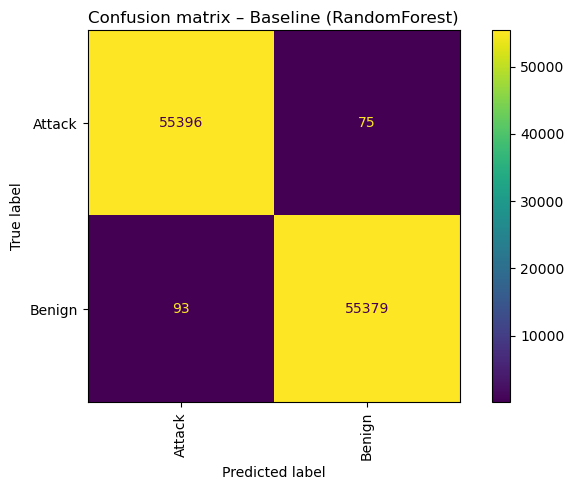

ROC AUC (binary): 0.9997


In [8]:
# --- Explanation (cell 8: training the best baseline & test evaluation) ---
# This cell trains the selected baseline model on the training data and
# evaluates it on the held‑out test set:
# - `best_pipe` is a Pipeline that combines the common `preprocess`
#   transformer with the `best_clf` chosen from cross‑validation.
# - `best_pipe.fit(X_train, y_train_use)` trains both the preprocessing
#   steps and the classifier using the (possibly binarised) training
#   labels.
# - `y_pred` are the predicted labels for `X_test`.
# - A detailed classification report is computed on the test set with
#   `classification_report(..., output_dict=True)` and displayed as a
#   DataFrame. It includes precision, recall and F1‑score for each
#   class, as well as macro/weighted averages.
# - The main aggregate metrics (accuracy, macro precision, macro recall
#   and macro F1‑score) are computed explicitly and printed in a single
#   line for convenience.
# - A confusion matrix is computed using the sorted list of unique test
#   labels and visualised with `ConfusionMatrixDisplay`. This shows how
#   often each class is correctly recognised or confused with others.
# - If the best model exposes `predict_proba`, the helper function
#   `try_macro_roc_auc` is called to compute and print a ROC‑AUC based
#   metric for additional diagnostic insight.

# =====================================
# 8) Final training of the best baseline & test evaluation
# =====================================

best_pipe = Pipeline([("prep", preprocess), ("clf", best_clf)])
best_pipe.fit(X_train, y_train_use)
y_pred = best_pipe.predict(X_test)

print("=== Test set classification report (baseline) ===")
rep = classification_report(y_test_use, y_pred, output_dict=True, zero_division=0)
display(pd.DataFrame(rep).T)

acc = accuracy_score(y_test_use, y_pred)
prec = precision_score(y_test_use, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test_use, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test_use, y_pred, average="macro", zero_division=0)
print(f"Accuracy: {acc:.4f} | Precision_macro: {prec:.4f} | Recall_macro: {rec:.4f} | F1_macro: {f1:.4f}")

labels_sorted = sorted(pd.unique(y_test_use))
cm = confusion_matrix(y_test_use, y_pred, labels=labels_sorted)
disp = ConfusionMatrixDisplay(cm, display_labels=labels_sorted)
fig = disp.plot(include_values=True, xticks_rotation=90).figure_
fig.set_size_inches(7,5)
plt.title(f"Confusion matrix – Baseline ({best_name})")
plt.tight_layout()
plt.show()

if hasattr(best_pipe.named_steps["clf"], "predict_proba"):
    try_macro_roc_auc(best_pipe, X_test, y_test_use)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters (GridSearchCV): {'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best CV macro-F1: 0.9985899931506083

=== Tuned RandomForest – Test set performance ===


,precision,recall,f1-score,support
Attack,0.998108,0.998774,0.998441,55471.000000
Benign,0.998773,0.998107,0.998440,55472.000000
accuracy,0.998441,0.998441,0.998441,0.998441
macro avg,0.998441,0.998441,0.998441,110943.000000
weighted avg,0.998441,0.998441,0.998441,110943.000000


Tuned RF – Accuracy: 0.9984 | Precision_macro: 0.9984 | Recall_macro: 0.9984 | F1_macro: 0.9984


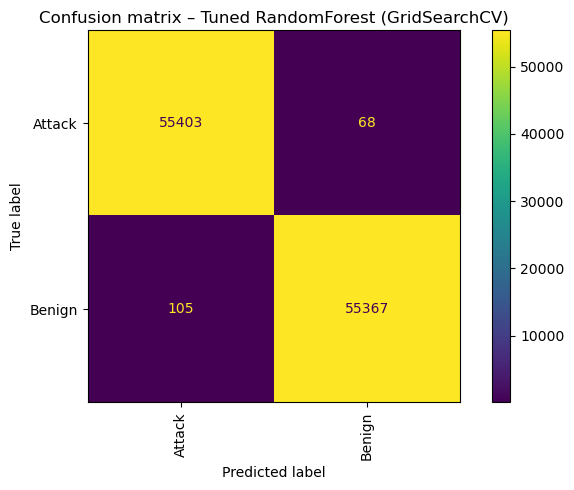

ROC AUC (binary): 0.9999


In [9]:
# --- Explanation (cell 9: RandomForest hyperparameter tuning) ---
# This cell focuses on improving the RandomForest model using a grid
# search over a small hyperparameter space:
# - `rf_base` defines a baseline RandomForestClassifier with:
#     * 200 trees,
#     * class_weight="balanced",
#     * parallel training (`n_jobs=-1`),
#     * a fixed random seed.
# - `rf_pipe` is a Pipeline with the common `preprocess` transformer and
#   the `rf_base` classifier.
# - `param_grid` specifies the hyperparameters to explore:
#     * number of trees (`clf__n_estimators`),
#     * maximum tree depth (`clf__max_depth`),
#     * minimum samples to split a node (`clf__min_samples_split`),
#     * minimum samples per leaf (`clf__min_samples_leaf`),
#     * maximum number of features considered at each split
#       (`clf__max_features`).
# - `cv_grid` is a StratifiedKFold with 3 folds used inside
#   GridSearchCV.
# - `rf_grid` is a GridSearchCV object that:
#     * wraps the pipeline,
#     * explores all combinations in `param_grid`,
#     * optimises the macro‑F1 score,
#     * runs cross‑validation in parallel (`n_jobs=-1`),
#     * prints some progress information (verbose=2).
# - `rf_grid.fit(X_train, y_train_use)` runs the grid search on the
#   training data.
# - The best set of hyperparameters and the corresponding cross‑validated
#   macro‑F1 score are printed.
# - `rf_best_pipe` stores the best estimator (pipeline + tuned RF).
# - The tuned model is then evaluated on the test set:
#     * predictions `y_pred_rf` are computed,
#     * a classification report is displayed as a DataFrame,
#     * accuracy, macro precision, macro recall and macro F1‑score are
#       computed and printed,
#     * a confusion matrix is plotted for the tuned model.
# - If the tuned RandomForest supports `predict_proba`, the ROC‑AUC based
#   evaluation helper `try_macro_roc_auc` is also run on the test data.

# =====================================
# 9) Hyperparameter tuning of RandomForest with GridSearchCV
# =====================================

rf_base = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

rf_pipe = Pipeline([("prep", preprocess), ("clf", rf_base)])

param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 15, 30],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"],
}

cv_grid = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv_grid,
    n_jobs=-1,
    verbose=2,
)

rf_grid.fit(X_train, y_train_use)

print("Best parameters (GridSearchCV):", rf_grid.best_params_)
print("Best CV macro-F1:", rf_grid.best_score_)

rf_best_pipe = rf_grid.best_estimator_

print("\n=== Tuned RandomForest – Test set performance ===")
y_pred_rf = rf_best_pipe.predict(X_test)
rep_rf = classification_report(y_test_use, y_pred_rf, output_dict=True, zero_division=0)
display(pd.DataFrame(rep_rf).T)

acc_rf = accuracy_score(y_test_use, y_pred_rf)
prec_rf = precision_score(y_test_use, y_pred_rf, average="macro", zero_division=0)
rec_rf = recall_score(y_test_use, y_pred_rf, average="macro", zero_division=0)
f1_rf = f1_score(y_test_use, y_pred_rf, average="macro", zero_division=0)
print(f"Tuned RF – Accuracy: {acc_rf:.4f} | Precision_macro: {prec_rf:.4f} | Recall_macro: {rec_rf:.4f} | F1_macro: {f1_rf:.4f}")

labels_sorted = sorted(pd.unique(y_test_use))
cm_rf = confusion_matrix(y_test_use, y_pred_rf, labels=labels_sorted)
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=labels_sorted)
fig = disp_rf.plot(include_values=True, xticks_rotation=90).figure_
fig.set_size_inches(7,5)
plt.title("Confusion matrix – Tuned RandomForest (GridSearchCV)")
plt.tight_layout()
plt.show()

if hasattr(rf_best_pipe.named_steps["clf"], "predict_proba"):
    try_macro_roc_auc(rf_best_pipe, X_test, y_test_use)


,feature,importance
0,Destination Port,0.089827
1,Fwd Packet Length Max,0.066669
2,Packet Length Variance,0.061830
3,Avg Fwd Segment Size,0.059052
4,Avg Bwd Segment Size,0.056349
5,Init_Win_bytes_forward,0.051297
6,Init_Win_bytes_backward,0.049169
7,Average Packet Size,0.048360
8,Subflow Fwd Bytes,0.047301
9,Max Packet Length,0.042471


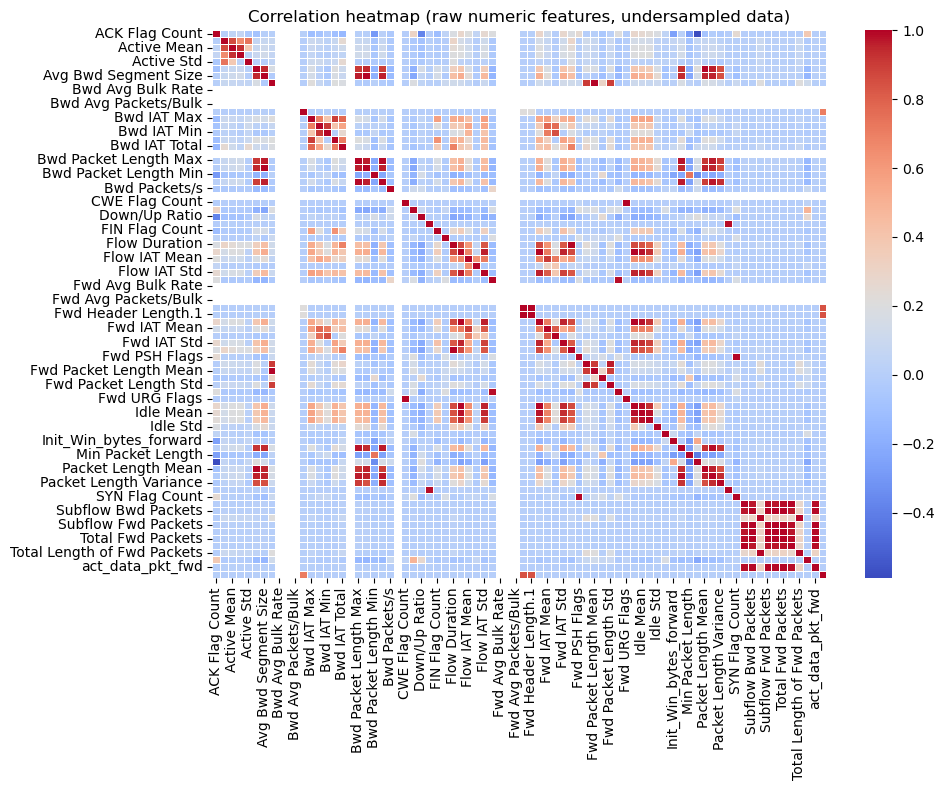

In [10]:
# --- Explanation (cell 10: feature importance & correlations) ---
# This cell analyses which features are most important for the tuned
# RandomForest model and inspects correlations between raw numeric
# features:
# - `feat_names = feature_names_from_ct(preprocess, X_train)` recovers
#   the list of feature names as seen by the model after the
#   ColumnTransformer.
# - `show_top_features(rf_best_pipe, feat_names, k=25)` uses the helper
#   function from cell 6 to display the 25 most important features
#   according to the tuned RandomForest.
# - `num_cols_corr` selects the numeric columns from the *balanced raw
#   DataFrame* (`df_balanced`).
# - `corr_matrix` is the Pearson correlation matrix between these
#   numeric features.
# - A heatmap is drawn with seaborn to visualise the correlations. This
#   helps understand which features are strongly related and whether the
#   dataset contains groups of highly correlated variables.

# =====================================
# 10) Feature importance & correlation analysis
# =====================================

feat_names = feature_names_from_ct(preprocess, X_train)
show_top_features(rf_best_pipe, feat_names, k=25)

num_cols_corr = df_balanced.select_dtypes(include=[np.number]).columns
corr_matrix = df_balanced[num_cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation heatmap (raw numeric features, undersampled data)")
plt.tight_layout()
plt.show()


In [11]:
# --- Explanation (cell 11: saving the tuned model) ---
# This final cell serialises the best tuned RandomForest pipeline so that
# it can be reused later without retraining:
# - Imports `joblib`, a lightweight library for serialising Python
#   objects (commonly used with scikit‑learn models).
# - Assigns the tuned RandomForest pipeline (`rf_best_pipe`) to
#   `best_model` for clarity.
# - Defines a filename
#   "CICIDS2017_tuned_randomforest_undersampled.joblib" for the saved
#   model.
# - Calls `joblib.dump(best_model, filename)` to write the model to
#   disk.
# - Prints the path of the saved model file so that the user knows where
#   it is stored.

# =====================================
# 11) Save the tuned model
# =====================================

import joblib

best_model = rf_best_pipe
filename = "CICIDS2017_tuned_randomforest_undersampled.joblib"
joblib.dump(best_model, filename)
print("Model saved to:", filename)


Model saved to: CICIDS2017_tuned_randomforest_undersampled.joblib


## 12) Conclusion

In this notebook we:

- Loaded and merged multiple CICIDS2017 CSV files  
- Strongly reduced the Benign class using undersampling to limit its dominance  
- Built a clean preprocessing pipeline with feature pruning, imputation and scaling  
- Compared several baseline models via stratified cross-validation  
- Performed a GridSearchCV on a RandomForest pipeline to tune key hyperparameters  
- Evaluated both the baseline and the tuned model on a held-out test set  
- Interpreted the tuned model through feature importance and correlation analysis  
